In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_file_from_google_drive

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import sys
import argparse
import os
import time
from os.path import join
import csv

print('PyTorch version:', torch.__version__)

# install wget for data sharing
# !pip install wget
import wget

PyTorch version: 2.0.1


In [2]:
from torchvision import models
import time

In [3]:
# FCN ResNet50
fcn50  = models.segmentation.fcn_resnet50(pretrained=True).eval()
# FCN ResNet101
fcn101 = models.segmentation.fcn_resnet101(pretrained=True).eval()
# DeepLab ResNet50
deepL50  = models.segmentation.deeplabv3_resnet50(pretrained=True).eval()
# DeepLab ResNet101
deepL101 = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `w

In [4]:
# Define the helper function
def decode_segmap(image, nc=21):
  ## Color palette for visualization of the 21 classes
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [5]:
def segment(net, path, show_orig=True,transform=None, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  input_image = transform(img).unsqueeze(0).to(dev)
  out = net.to(dev)(input_image)['out']
  segm = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  segm_rgb = decode_segmap(segm)
  plt.imshow(segm_rgb); plt.axis('off'); plt.show()

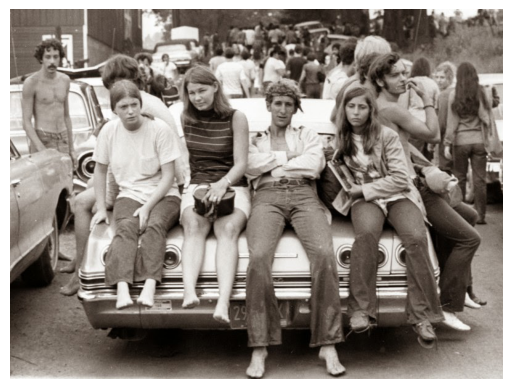

In [6]:
img2seg_path = './woodstock2.jpg'

img = Image.open(img2seg_path)
# show image
plt.imshow(img); plt.axis('off'); plt.show()

In [7]:
custom_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]) # T.Resize(640), #T.CenterCrop(224)...

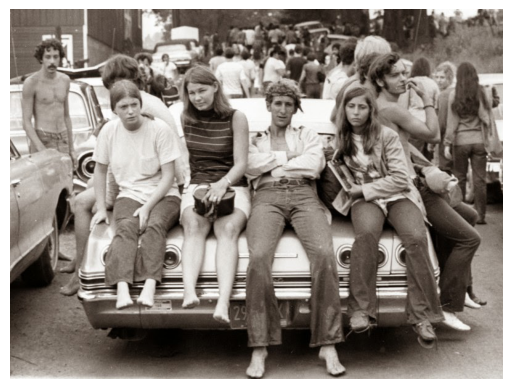

Segmentation Image on FCN ResNet50 backbone


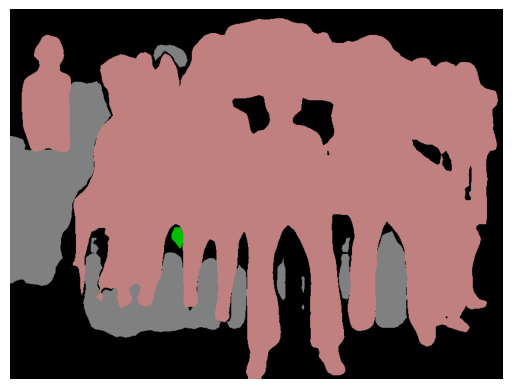

Segmentation Image on FCN ResNet101 backbone


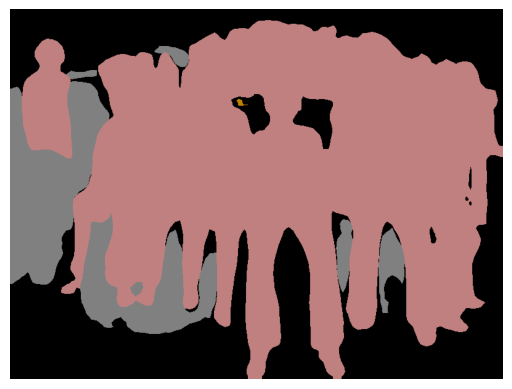

Segmentation Image on DeepLabv3 ResNet50 backbone


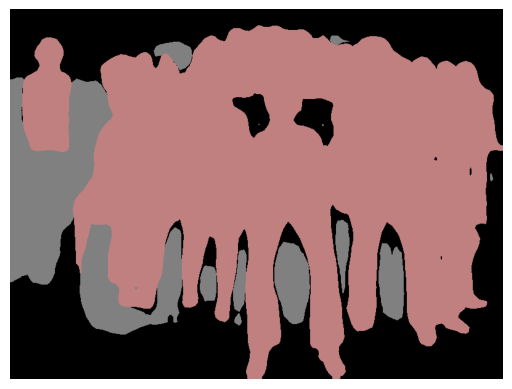

Segmentation Image on DeepLabv3 ResNet101 backbone


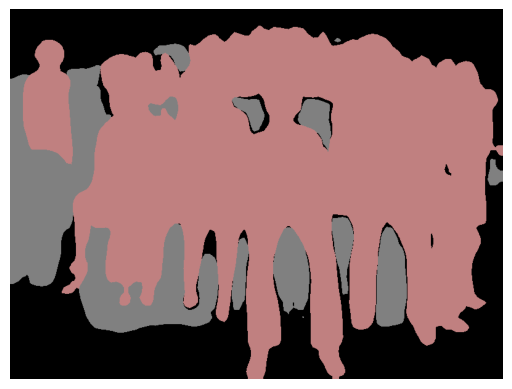

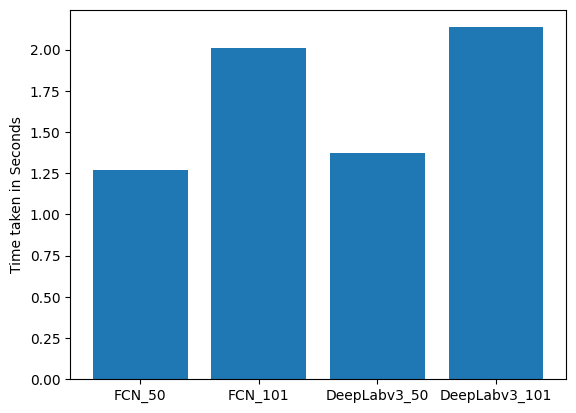

In [10]:
resize = False

# read image
img = Image.open(img2seg_path)

if resize == True:
    img = img.resize((250,180), resample=Image.NEAREST)
    
# show image
plt.imshow(img); plt.axis('off'); plt.show()

# show FCN50 segmentation results
plt.figure()
print ('Segmentation Image on FCN ResNet50 backbone')
st = time.time()
segment(fcn50, img2seg_path, False, custom_transform, 'cpu')
#segment(fcn50, './imageToSegment.png', False, custom_transform)
et = time.time()
fcn50_time = et - st

# show FCN101 segmentation results
plt.figure()
print ('Segmentation Image on FCN ResNet101 backbone')
st = time.time()
segment(fcn101, img2seg_path, False, custom_transform, 'cpu')
# segment(fcn101, './imageToSegment.png', False, custom_transform)
et = time.time()
fcn101_time = et - st

# show DeepLab50 segmentation results
plt.figure()
print ('Segmentation Image on DeepLabv3 ResNet50 backbone')
st = time.time()
segment(deepL50, img2seg_path, False, custom_transform, 'cpu')
# segment(deepL50, './imageToSegment.png', False, custom_transform)
et = time.time()
deepL50_time = et - st

# show FCN101 segmentation results
plt.figure()
print ('Segmentation Image on DeepLabv3 ResNet101 backbone')
st = time.time()
segment(deepL101, img2seg_path, False, custom_transform, 'cpu')
#segment(deepL101, './imageToSegment.png', False, custom_transform)
et = time.time()
deepL101_time = et - st

plt.figure()
plt.bar([0.1, 0.2, 0.3, 0.4], [fcn50_time, fcn101_time, deepL50_time, deepL101_time], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2, 0.3, 0.4], ['FCN_50', 'FCN_101', 'DeepLabv3_50', 'DeepLabv3_101'])
plt.show()